# 3) Test di Pearson

Il test di Pearson è un test non parametrico (cioè non dipende dai parametri) che funge da criterio di confronto per la scelta della miglior coppia dei parametri a e b generati dai tre metodi analitici (metodo dei momenti, metodo della massima verosimiglianza e metodo dei minimi quadrati).

## Caricamento librerie

In [2]:
import os
from pandas import *
import pandas as pd
import numpy as np
from numpy import linspace
import datetime as datetime
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy.stats import genextreme, gumbel_r
from statsmodels.distributions.empirical_distribution import ECDF

## Caricamento dati

Per effettuare il test di Pearson occorre riportare i dati sperimentali e i parametri a e b ottenuti dai 3 metodi analitici

In [3]:
# Dati sperimentali
data = pd.ExcelFile('MassimiDiPrecipCavalese.xls')
data
data.sheet_names
df = data.parse('DATI', header = 2)
df.columns
df.rename(columns = {'anno':'Anno'}, inplace = True)
df.set_index("Anno", inplace = True)
df.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
Anno,,,,,
1962,24.0,41.6,42.8,42.8,60.5
1963,10.4,15.0,18.8,32.0,35.8
1964,28.6,34.8,38.4,40.0,56.4
1965,18.8,30.2,31.0,35.2,39.2
1966,21.0,22.0,33.0,59.6,102.2


In [4]:
# Parametri a e b ottenuti con i 3 metodi analitici
df_aEb_m = pd.read_pickle("df_aEb_m")
df_aEb_mv = pd.read_pickle("df_aEb_mv")
df_aEb_mq = pd.read_pickle("df_aEb_mq")

## Ricerca delle migliori coppie dei parametri a e b

Si definisce adesso la funzione $\chi^2$

$$\chi^2 = \frac{1}{val. atteso}\sum_{i=1}^k (val. atteso - val. osservato)^2$$

Al termine del test di Pearson si sceglie la coppia di parametri per cui il $\chi^2$ è più piccolo.

In [10]:
def X2(data, df_aEb, ora):
    data = data.dropna()
    
    # Funzione di Gumbel con parametri prefissati
    rv = gumbel_r(loc = df_aEb.at["a", ora], scale = df_aEb.at["b", ora])
    
    # Suddivisione del campo di probabilità in 5 parti
    q = [0.2, 0.4, 0.6, 0.8, 1]
    
    # Inverso della curva di probabilità (biettiva) tramite il comando ppf -> fornisce il valore dell'ascissa
    hNh = rv.ppf(q)
    
    # Quantificazione dei punti presenti in ciascun intervallo sulle ascisse attraverso la ECDF
    ecdf = ECDF(data[ora])
    r = ecdf(hNh) # probabilità della presenza dei dati negli intervalli considerati
    lNh = len(data[ora]) # numero tot. dei dati relativo ad ogni fascia oraria
    o0 = lNh * r # numero di dati presente in ogni intervallo
    
    # Numero di punti atteso in funzione della distribuzione di probabilità
    v_atteso = [0.2 * lNh for i in range(len(r))]
    
    # Numero di punti misurato per ogni intervallo
    v_osservato = o0 - np.append([0], np.delete(o0, -1))
    
    # Funzione del chi quadro
    return ((v_osservato - v_atteso)**2 / v_atteso).sum()

Per una migliore lettura si riportano i valori del $\chi^2$ per ogni metodo e per ogni intervallo per poter scegliere il metodo con il $\chi^2$ minore.

In [12]:
T = []
ore = ["1 ora","3 ore", "6 ore", "12 ore", "24 ore"]
for i in df.columns:
    # Valori del chi quadro relativi ad ogni fascia oraria per ogni metodo 
    T = T + [[X2(df, df_aEb_m, i), X2(df, df_aEb_mv, i), X2(df,df_aEb_mq, i)]]
df_X2 = pd.DataFrame(T, index = ore, columns = ["Momenti", "Max verosomiglianza", "Minimi quadrati"]).T 
df_X2

,1 ora,3 ore,6 ore,12 ore,24 ore
Momenti,0.615385,8.051282,4.974359,3.435897,2.410256
Max verosomiglianza,0.358974,10.102564,4.974359,3.435897,1.384615
Minimi quadrati,0.358974,6.769231,2.666667,1.384615,1.384615


Scelta delle migliori coppie di a e b.

In [15]:
best = []
for i in df_X2.columns:
    b = (df_X2.min()[i])
    
    if b == df_X2[i]['Momenti']:
        best.append(df_aEb_m[i])
        
    elif b == df_X2[i]['Max verosomiglianza']:
        best.append(df_aEb_mv[i])
   
    elif b == df_X2[i]['Minimi quadrati']:
        best.append(df_aEb_mq[i])

df_best = pd.DataFrame(best, index = ore, columns=["a","b"]).T 
df_best

,1 ora,3 ore,6 ore,12 ore,24 ore
a,17.096393,23.964007,30.801410,39.728183,51.263666
b,5.723790,6.604094,8.995085,11.323566,14.547560


In [30]:
df_best.to_pickle("df_best_aEb")

## Costruzione del grafico

Definire una funzione che ritorna l'espressione della curva di Gumbel.

In [22]:
def gumbel(x, df_g, time):
    return np.exp( - np.exp( - (x - df_g[time]["a"]) / df_g[time]["b"])) 

Determinare i valori minimi e massimi di precipitazione per tutte le fasce orarie.

In [23]:
x_gumbel = np.linspace(df.min()[0], df.max()[4], 100)

Definire un dataframe contenente le espressione delle distribuzioni di Gumbel interpolate, nelle diverse fasce orarie.

In [24]:
df_pearson = pd.DataFrame([gumbel(x_gumbel, df_best, "1 ora"),
                 gumbel(x_gumbel, df_best, "3 ore"),
                 gumbel(x_gumbel, df_best, "6 ore"),
                 gumbel(x_gumbel, df_best, "12 ore"),
                 gumbel(x_gumbel, df_best, "24 ore")]).T
df_pearson.index = x_gumbel
df_pearson.columns = ["1 ora","3 ore","6 ore","12 ore","24 ore"]
df_pearson.head()

,1 ora,3 ore,6 ore,12 ore,24 ore
10.200000,0.035568,0.000323,0.000051,0.000001,4.943930e-08
11.276768,0.063028,0.001082,0.000156,0.000004,1.641752e-07
12.353535,0.101250,0.003024,0.000420,0.000013,5.004442e-07
13.430303,0.149953,0.007238,0.001010,0.000037,1.408866e-06
14.507071,0.207620,0.015192,0.002200,0.000094,3.683950e-06


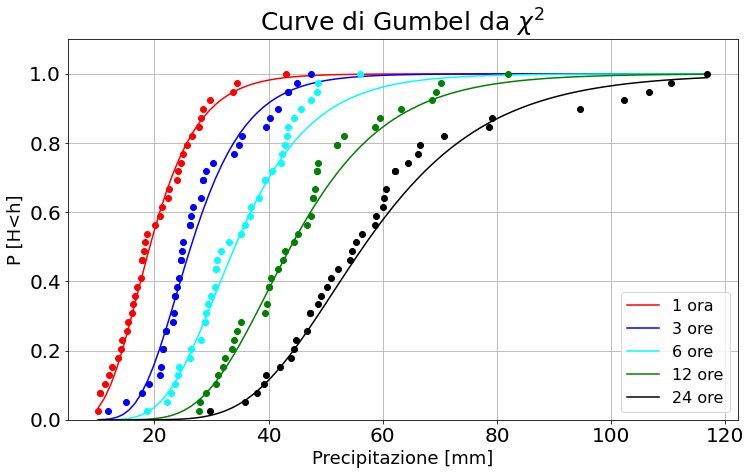

In [31]:
#Curve di Gumbel relative alle varie fasce orarie
plt.rc('xtick', labelsize = 20)
plt.rc('ytick', labelsize = 20)
colori = ["red", "blue", "cyan", "green", "black"]
ax_p = df_pearson.plot(color = colori, figsize = (12,7))
ax_p.set_title('Curve di Gumbel da $\chi^2$', fontsize = 25)
ax_p.set_xlabel('Precipitazione [mm]', fontsize = 18)
ax_p.set_ylabel('P [H<h]', fontsize = 18)
plt.legend(prop = {"size":16}, loc = 4)
ax_p.grid()
# Rappresentazione dell'andamento effettivo dei dati determinati sperimentalmente
def componenti(data, colore, ora):  
    data = data[ora].dropna()
    ecdf = ECDF(data)
    dot = ax_p.plot(data, ecdf(data), 'o', c = colore)
    return dot

for i in range(len(colori)):
    comp = componenti(df, colori[i], ore[i]) 
ax_p.set_ybound(lower = 0, upper = 1.1)
plt.savefig("Gumbel_pearson.png", dpi = 600)